## BITCOIN TWITTER SENTIMENT AND PRICE PREDICTION USING MACHINE LEARNING


**Hypothesis**  
Hypothesis 1: Bitcoin sentiment analysis using NLP (EDA)
Hypothesis 2: Using machine learning classification models to predict Bitcoin Returns 

**Brief methodology**  
Source of data: Yahoo Finance and Kaggle   

- The study uses approximately 6 months of tweets obtained from twitter during the period 2021-02-05 to 2021-09-10. 
- The df tweets will be merged with a df that contains a computed binary classification of daily Bitcoin returns. 
- The overall dataset will have 500,000 observations in sentiment analysis and 15,000 for the machine models. 
- Preprocessing: Regex expression, calculating daily returns and stop words.  
- Sentiment analysis: Polarity and Subjectivity.   
- Python tools: Pandas, NumPy, Regex and Scikit-learn, Textblob, NLTK, Datetime, Wordcloud. 
- Machine learning models: Logistic regression and Random Forest: TF-IDF Vectorizer and Count Vectorization.   

### Importing packages and data

In [44]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from datetime import datetime
from datetime import timedelta
from textblob import TextBlob
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import  plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve, roc_auc_score, average_precision_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
import nltk

In [16]:
# CSV file for computed bitcoin returns 
df_btc_returns = pd.read_csv("BTC-USD.csv")

In [8]:
# CSV file containing tweets from twitter 
df = pd.read_csv("Bitcoin_tweets.csv")

C:\Users\kavi_\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (5,6,7,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Data Cleaning and Preprocessing: Bitcoin tweets

In [9]:
df.head(3)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534.0,7605,4838,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,['bitcoin'],Twitter Web App,False
1,CryptoND,NaN,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17 20:12:10,6769.0,1532,25483,False,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""...","['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False
2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128.0,332,924,False,2021-02-10 23:54:48,"Guys evening, I have read this article about B...",NaN,Twitter Web App,False


In [10]:
# rows and columns of the dataset
df.shape

(1232809, 13)

In [11]:
# Obtain a random sample of 500,000 Bitcoin tweets
df = df.sample(n = 500000, random_state = 1)

# Rest the index of the dataframe
df = df.reset_index(drop = True)

In [12]:
# Rows and columns
df.shape

(500000, 13)

In [13]:
# df view
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_name         499990 non-null  object 
 1   user_location     263066 non-null  object 
 2   user_description  441294 non-null  object 
 3   user_created      500000 non-null  object 
 4   user_followers    499998 non-null  float64
 5   user_friends      499998 non-null  object 
 6   user_favourites   499998 non-null  object 
 7   user_verified     499998 non-null  object 
 8   date              499998 non-null  object 
 9   text              499998 non-null  object 
 10  hashtags          493200 non-null  object 
 11  source            498648 non-null  object 
 12  is_retweet        499980 non-null  object 
dtypes: float64(1), object(12)
memory usage: 49.6+ MB


In [14]:
# Remove unwanted columns
df.drop(["user_followers", "user_friends", "user_favourites", "user_verified", "user_created",
          "source", "is_retweet", "hashtags", "user_location", "user_description"], axis = 1, inplace = True)

In [15]:
# Split the date column: time and date
df[["date", "time"]]  = df['date'].str.split(" ", n = 1, expand = True)

# Rename the columns
df.rename(columns = {"text" : "tweets"}, inplace = True)

In [16]:
# df view
df.head(3)

,user_name,date,tweets,time
0,yowie_bot,2021-08-05,"#BTC ️⬇️ -0.79% to AUD$ 52,361\n\nRSI 3: 🐂 Bul...",15:07:17
1,Cryptocurrencies / USD,2021-04-18,🔄 Prices update in $USD (1 hour):\n\n$BTC - 55...,18:04:11
2,D.Y.M,2021-08-19,Is Ripple a Safe Cryptocurrency Investment? | ...,13:13:43


###### **_Micro level data cleaning: Using regex and building cleaning functions_**

In [39]:
# Building a general data cleaning function using regex
def clean_text(text):
    text = str(text).lower() # lower case
    text = re.sub(r"@[A-Za-z0-9]+", '', str(text)) # removes text after @
    text = re.sub(r"([^0-9A-Za-z \t])", "", str(text)) # removes special characters
    text = re.sub(r"https?:?/?[A-Za-z0-0]+", "", str(text)) # removes the hyperlink
    text = re.sub(r"[0-9]", "", str(text)) # removes numerical values
    return text 

# Building a specific cleaning function for date column
def clean_date_time(dt):
    dt = re.sub(r"[^0-9:-]", "", str(dt))
    return(dt)

In [40]:
# applying the cleaning function "clean_text" to the columns: user_name and tweets
df["tweets"] = df["tweets"].apply(clean_text)
df["user_name"] = df["user_name"].apply(clean_text)

# applying the date cleaning function to the column: date
df["date"] = df["date"].apply(clean_date_time)

In [41]:
# drropping columns with whitespace following the use of regex function
df.drop(df.index[df['date'] == ''], inplace = True)

In [42]:
# df view
df.head(5)

,user_name,date,tweets,time
0,yowiebot,2021-08-05,btc to aud rsi bullishrsi bullishtraject...,15:07:17
1,cryptocurrencies usd,2021-04-18,prices update in usd hourbtc eth d...,18:04:11
2,dym,2021-08-19,is ripple a safe cryptocurrency investment th...,13:13:43
3,sams allstars,2021-07-21,next crypto low cap gem to pop incredible upd...,12:31:36
4,lightningstrategy,2021-07-21,join our m sat bitcoin lightningnetwork liquid...,17:52:16


### Data cleaning and Processing: Bitcoin returns

In [55]:
# Data from yahoo finance of Bitcoin price
df_btc_returns.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-02-05,36931.546875,38225.906250,36658.761719,38144.308594,38144.308594,58598066402
1,2021-02-06,38138.386719,40846.546875,38138.386719,39266.011719,39266.011719,71326033653


In [58]:
df_btc_returns.drop(["High", "Low", "Volume", "Adj Close"], axis = 1, inplace = True)

# rename the columns
df_btc_returns.rename(columns = {"Date" : "date", "Close" : "close_price", "Open" : "open_price"}, inplace = True)

In [59]:
# Get Floating division of dataframe using .div
df_btc_returns["daily_returns"] = df_btc_returns["close_price"].div(df_btc_returns["open_price"])

In [60]:
df_btc_returns.head(3)

,date,open_price,close_price,daily_returns
0,2021-02-05,36931.546875,38144.308594,1.032838
1,2021-02-06,38138.386719,39266.011719,1.029567
2,2021-02-07,39250.191406,38903.441406,0.991166


In [61]:
# Classifies returns as 1 (closing price > open price) and 0 (closing price < open price)
df_btc_returns["daily_returns"] = df_btc_returns["daily_returns"].apply(lambda x : 0 if x < 1 else 1)

In [63]:
df_btc_returns.head(3)

,date,open_price,close_price,daily_returns
0,2021-02-05,36931.546875,38144.308594,1
1,2021-02-06,38138.386719,39266.011719,1
2,2021-02-07,39250.191406,38903.441406,0


###### **_Merging two dataframes: Bitcoin tweets and Bitcoin returns_**

In [64]:
# Convert both dataframe "date" from object to dataframe: merge purposes

df["date"] = pd.to_datetime(df["date"])

df_btc_returns["date"] = pd.to_datetime(df_btc_returns["date"])

In [69]:
print(df_btc_returns["date"].nunique())
print(df["date"].sort_values().nunique())

218
78


In [70]:
# merge dataframes to new created dataframe:
df_btc = pd.merge(df, df_btc_returns, how = "left", on = ["date", "date"])

In [71]:
df_btc.head(3)

,user_name,date,tweets,time,open_price,close_price,daily_returns
0,yowiebot,2021-08-05,btc to aud rsi bullishrsi bullishtraject...,15:07:17,39744.515625,40869.554688,1
1,cryptocurrencies usd,2021-04-18,prices update in usd hourbtc eth d...,18:04:11,60701.886719,56216.183594,0
2,dym,2021-08-19,is ripple a safe cryptocurrency investment th...,13:13:43,44741.882813,46717.578125,1


In [72]:
print(df_btc["date"].sort_values().nunique())

78


### Hypothesis 1: NLP to analyze Bitcoin sentiment

#### **NLP: Wordcloud**

In [77]:
# Removing nltk stop words
nltk_stopwords = nltk.corpus.stopwords.words("english")

# Removing custom stop words that would inherenlty be included in tweets but do not provide meaningful insights
custom_stop_words = ["bitcoin", "Bitcoin", "crypto", "bitcoin price", "btc", "Btc", "cryptocurrency", "eth",
                    "ethereum", "bsc"]
total_stopwords = nltk_stopwords + custom_stop_words

In [78]:
df_btc['tweets'] = df_btc['tweets'].apply(lambda x: ' '.join
                                                   ([word for word in x.split() if word not in (total_stopwords)]))

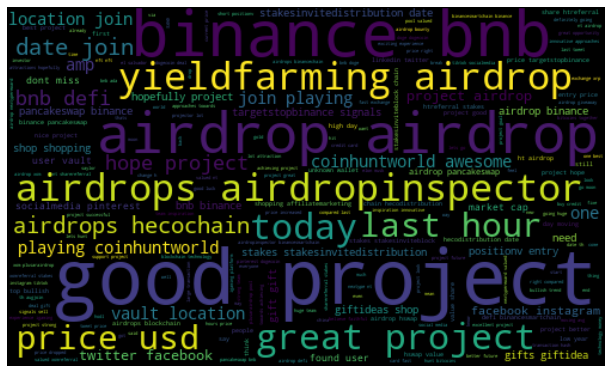

In [79]:
# Constructing the wordcloud
allwords = " ".join([twts for twts in df_btc["tweets"]]) 
wordcloud = WordCloud(width = 500, height = 300, random_state = 21).generate(allwords)
plt.figure(figsize = (15, 6.6))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

**_Findings: Two most importance words are "good" and "project"_**  
The words most frequent within the tweets are "good", "project", "airdrop", "bnb" and "binance"

#### **NLP: Subjectivity, Polarity and Sentiment**

In [80]:
# creating functions to get subjectivity and polarity
def getsubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getpolarity(text):
    return TextBlob(text).sentiment.polarity

In [81]:
# creating two columns " subjectivity and polarity"
df_btc["subjectivity"] = df_btc["tweets"].apply(getsubjectivity)

In [82]:
df_btc["polarity"] = df_btc["tweets"].apply(getpolarity)

In [83]:
# classify the sentiment 
def classify_sentiment(x):
    if x < 0:
        return "negative"
    elif x > 0:
        return "positive"
    else:
        return "neutral"

In [84]:
df_btc["sentiment"] = df_btc["polarity"].apply(classify_sentiment)

In [85]:
df_sentiment = df_btc[["date", "subjectivity", "polarity", "sentiment", "daily_returns",]]
df_sentiment.head(5)

,date,subjectivity,polarity,sentiment,daily_returns
0,2021-08-05,0.0,0.00,neutral,1
1,2021-04-18,0.0,0.00,neutral,0
2,2021-08-19,0.7,0.55,positive,1
3,2021-07-21,0.4,0.30,positive,1
4,2021-07-21,0.0,0.00,neutral,1


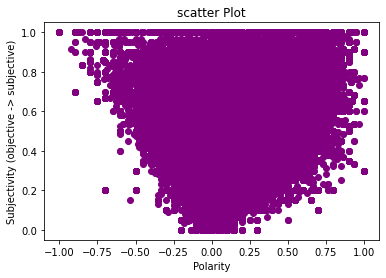

In [86]:
# illustrates the polarity and subjectivity of bitcoin tweets
plt.scatter(y = df_sentiment["subjectivity"], x = df_sentiment["polarity"], color = "Purple")
plt.title("scatter Plot")
plt.xlabel("Polarity")
plt.ylabel("Subjectivity (objective -> subjective)")
plt.show()

**_Findings: Tweets are more subjective and positive_**  
A higher distribution of the tweets are skewed to the right ( > 0.00) and above 0.50. This indicate most tweets represent a positive sentiment. 
The data is also more skewed on a higher subjective number > 0.50 indicating the texts are more subjective in nature.

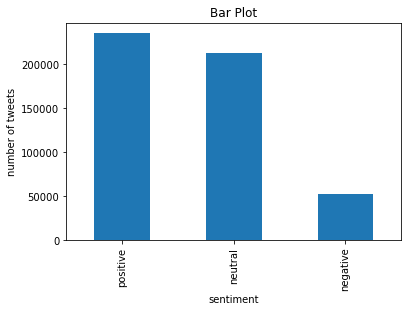

In [87]:
df_sentiment["sentiment"].value_counts().plot(kind = "bar")
plt.title("Bar Plot")
plt.xlabel("sentiment")
plt.ylabel("number of tweets")
plt.show()

**_Findings: Majority of the data are Positive tweets_**  
Positive tweets is represents the majority of the data followeed by neutral and negative as the least

### Hypothesis 2: Using machine learning to classify tweet on daily Bitcoin returns

In [29]:
# dataframe
df_btc = df_btc[["date", "tweets", "daily_returns"]]

In [30]:
# take a sample and drop NaN values
df_btc = df_btc.sample(n = 15000, random_state=1)
df_btc = df_btc.dropna()

In [31]:
# Rest the index of the dataframe
df_btc = df_btc.reset_index(drop = True)

In [32]:
df_btc.head(5)

,date,tweets,daily_returns
0,2021-08-08,explodingaltcoins moving jdkerh,0
1,2021-07-18,quick reminder stay tredbit us blockchain bina...,1
2,2021-08-18,wish project success sir become one best crypt...,1
3,2021-06-22,btcusd,1
4,2021-08-09,cryptos despite prospect broad taxation market...,1


#### Model 1: Logistic Regression

###### Part A: Count Vectorization

In [25]:
# Creating X and y variables: 
X = df_btc["tweets"]
y = df_btc["daily_returns"]

In [26]:
y.value_counts(normalize=True)

1    0.62742
0    0.37258
Name: daily_returns, dtype: float64

In [27]:
# Training - Test Split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.25, random_state = 1)

In [28]:
# initiatiate the class 
vectorizer = CountVectorizer()

# fit and transform the data 
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [29]:
# logistic regression class 
logreg = LogisticRegression(max_iter = 1000)
logreg.fit(X_train_vec, y_train)

LogisticRegression(max_iter=1000)

In [30]:
# Accuracy score of the model  
training_score = logreg.score(X_train_vec, y_train)
test_score = logreg.score(X_test_vec, y_test)
cv_score = cross_val_score(logreg, X_train_vec, y_train, cv=5)
mean_cv_score = cv_score.mean()

print("Training score:", training_score.round(2))
print("Test score:", test_score.round(2))
print("Cross validation score:" , cv_score.round(2))
print("Mean cross validation score:", mean_cv_score.round(2))

Training score: 0.92
Test score: 0.63
Cross validation score: [0.61 0.62 0.62 0.61 0.61]
Mean cross validation score: 0.61


##### Part B: Tf-IDF Vectorizer

In [33]:
# Creating X and y variables: 
X = df_btc["tweets"]
y = df_btc["daily_returns"]

In [34]:
# Training - Test Split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.25, random_state = 1)

In [35]:
# initiatiate the class 
tvec = TfidfVectorizer()

# fit and transform the data 
X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)

In [36]:
# logistic regression class 
log_reg = LogisticRegression(max_iter = 1000)
log_reg.fit(X_train_tvec, y_train)

LogisticRegression(max_iter=1000)

In [110]:
# Accuracy of the model
training_score = log_reg.score(X_train_tvec, y_train)
test_score = log_reg.score(X_test_tvec, y_test)
cv_score = cross_val_score(log_reg, X_train_tvec, y_train, cv=5)
mean_cv_score = cv_score.mean()

print("Training score:", training_score.round(2))
print("Test score:", test_score.round(2))
print("Cross validation score:" , cv_score.round(2))
print("Mean cross validation score:", mean_cv_score.round(2))

Training score: 0.76
Test score: 0.64
Cross validation score: [0.63 0.63 0.64 0.63 0.63]
Mean cross validation score: 0.63


#### Model 2: Random Forest 

###### Part A: Count Vectorization

In [36]:
# Creating X and y variables: 
X = df_btc["tweets"]
y = df_btc["daily_returns"]

In [37]:
# Training - Test Split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.25, random_state = 1)

In [38]:
# initiatiate the class 
vectorizer = CountVectorizer()

# fit and transform the data 
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [39]:
# Initiate the class
rfc = RandomForestClassifier(n_estimators = 5)
rfc.fit(X_train_vec, y_train)

RandomForestClassifier(n_estimators=5)

In [40]:
# Accuracy score of the model
training_score = rfc.score(X_train_vec, y_train)
test_score = rfc.score(X_test_vec, y_test)
cv_score = cross_val_score(rfc, X_train_vec, y_train, cv = 5)
mean_cv_score = cv_score.mean()

print("Training score:", training_score.round(2))
print("Test score:", test_score.round(2))
print("Cross validation score:" , cv_score.round(2))
print("Mean cross validation score:", mean_cv_score.round(2))

Training score: 0.93
Test score: 0.6
Cross validation score: [0.61 0.61 0.62 0.61 0.61]
Mean cross validation score: 0.61


##### Part B: TF-IDF Vectorizer

In [47]:
# Creating X and y variables: 
X = df_btc["tweets"]
y = df_btc["daily_returns"]

In [48]:
# training - test split 
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.25, random_state = 1)

In [49]:
# initiatiate the class 
tvec = TfidfVectorizer()

# fit and transform the data 
X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)

In [50]:
# Initiate the class
rfc = RandomForestClassifier(n_estimators = 5)
rfc.fit(X_train_tvec, y_train)

RandomForestClassifier(n_estimators=5)

In [46]:
# Accuracy score of the model
training_score = rfc.score(X_train_tvec, y_train)
test_score = rfc.score(X_test_tvec, y_test)
cv_score = cross_val_score(rfc, X_train_tvec, y_train, cv = 5)
mean_cv_score = cv_score.mean()

print("Training score:", training_score.round(2))
print("Test score:", test_score.round(2))
print("Cross validation score:" , cv_score.round(2))
print("Mean cross validation score:", mean_cv_score.round(2))

Training score: 0.93
Test score: 0.6
Cross validation score: [0.61 0.62 0.6  0.61 0.6 ]
Mean cross validation score: 0.61


#### Classification report and Confusion Matrix

##### Logistic Regression: TF-IDF Vectorizer

A classification and confusion matrix is constructed below for the highest accuracy machine learning model that generalizes well on unseen data based on the above computations

In [37]:
predictions = log_reg.predict(X_test_tvec)
predictions[0:5]

array([1, 0, 1, 1, 1], dtype=int64)

In [39]:
# Compute the actual predictions from y test data
actual_predictions = y_test[0:5].values
actual_predictions

array([1, 0, 1, 0, 1], dtype=int64)

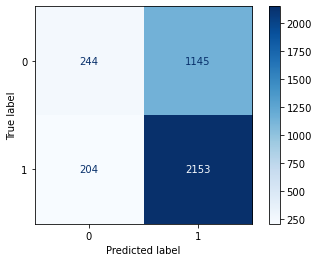

In [45]:
# Confusion Matrix
plot_confusion_matrix(log_reg, X_test_tvec, y_test, cmap='Blues', values_format='.0f')
plt.show()

In [41]:
# Compute the recall and precision score
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.54      0.18      0.27      1389
           1       0.65      0.91      0.76      2357

    accuracy                           0.64      3746
   macro avg       0.60      0.54      0.51      3746
weighted avg       0.61      0.64      0.58      3746



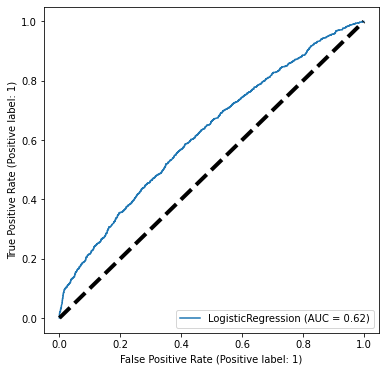

In [48]:
# Plot the ROC curve
fig, ax = plt.subplots(figsize=(6, 6))
plot_roc_curve(log_reg, X_test_tvec, y_test, ax=ax)
ax.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.show()